In [9]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-07-14
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from Function.snn_IZHIlayers import *
from Function.snn_plot import *
from Function.snn_simulation import *
from Function.snn_stimulation import *
from Function.snn_receptive_field_weights import *

from line_profiler import LineProfiler

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")\

# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU available: False
CUDA version: None
Using device: cpu


In [10]:
R = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output = [np.pi/2], plot_receptive_field = False,plot_ind = 1)

[1.5707963267948966]
torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_rf shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_rf shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_rf shape:  torch.Size([54, 54])
ra_intopn_rf shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([28, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([28, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([28, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([28, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn

Trials:   0%|          | 0/20 [00:00<?, ?it/s]

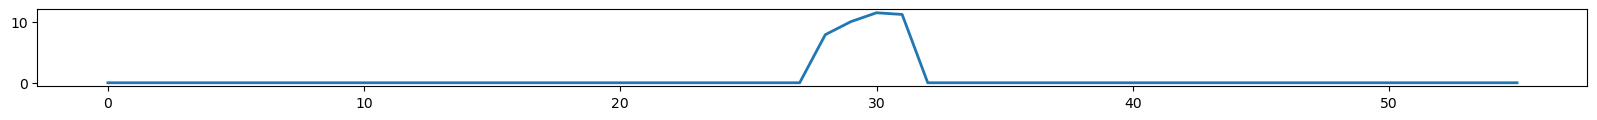

frequency:1 Hz    Mean Firing Rate(Hz): 0.7259398698806763


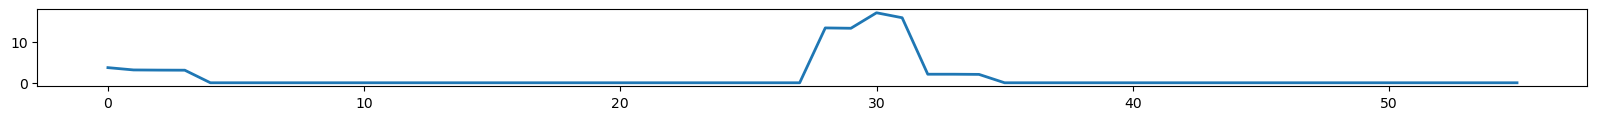

frequency:2 Hz    Mean Firing Rate(Hz): 1.4195488691329956


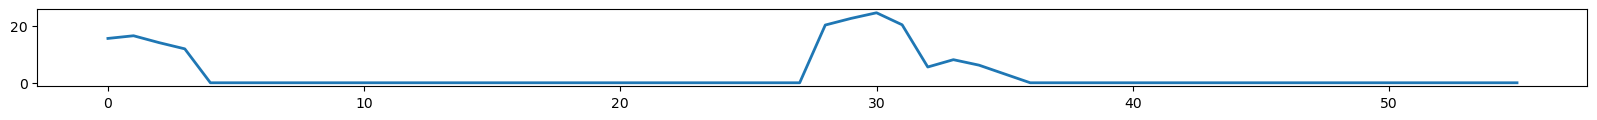

frequency:3 Hz    Mean Firing Rate(Hz): 3.036466121673584


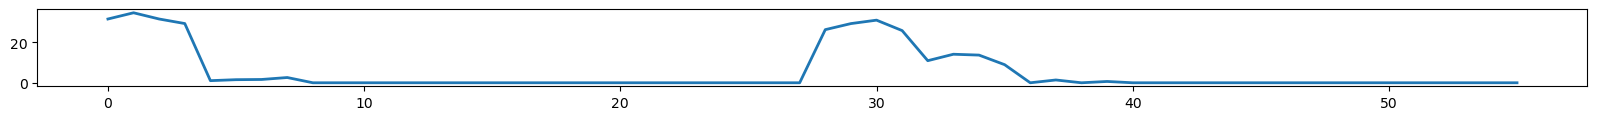

frequency:4 Hz    Mean Firing Rate(Hz): 5.304135322570801


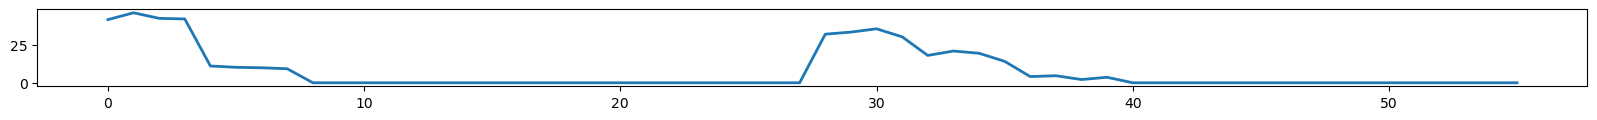

frequency:5 Hz    Mean Firing Rate(Hz): 7.775563716888428


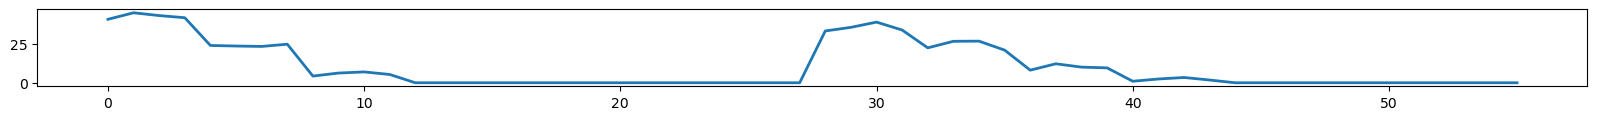

frequency:6 Hz    Mean Firing Rate(Hz): 10.369173049926758


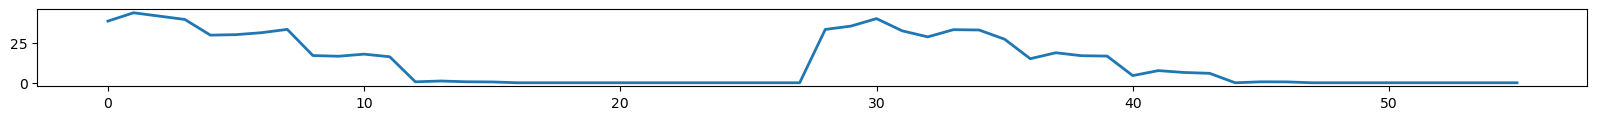

frequency:7 Hz    Mean Firing Rate(Hz): 12.904886245727539


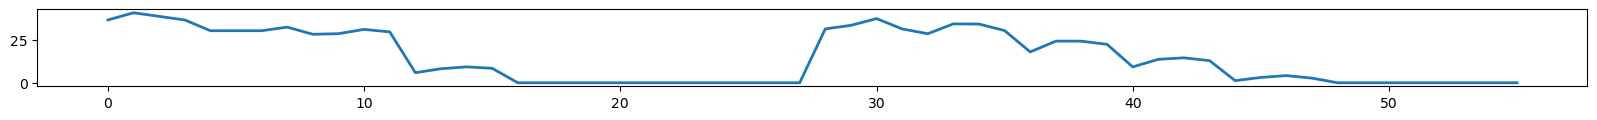

frequency:8 Hz    Mean Firing Rate(Hz): 15.045112609863281


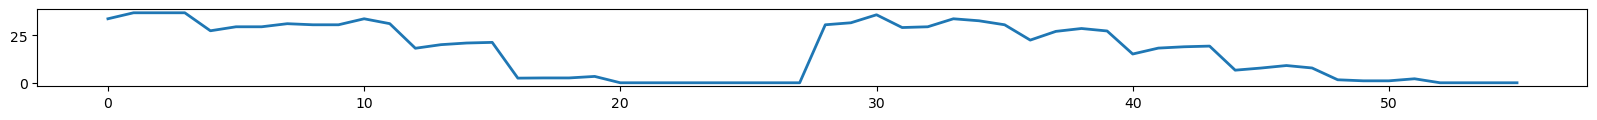

frequency:9 Hz    Mean Firing Rate(Hz): 16.89361000061035


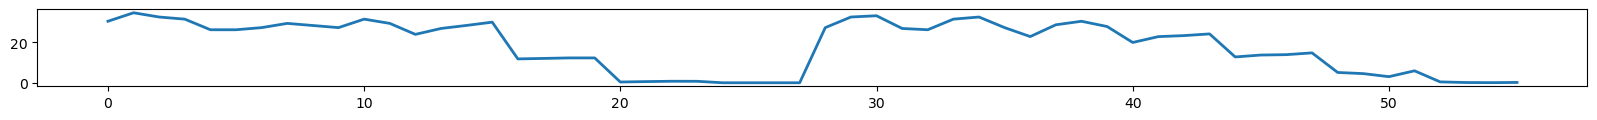

frequency:10 Hz    Mean Firing Rate(Hz): 18.393234252929688


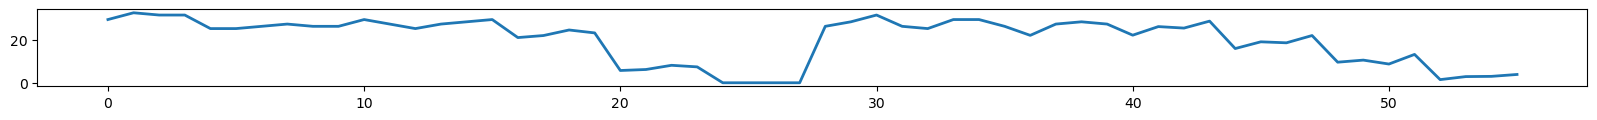

frequency:11 Hz    Mean Firing Rate(Hz): 20.14248275756836


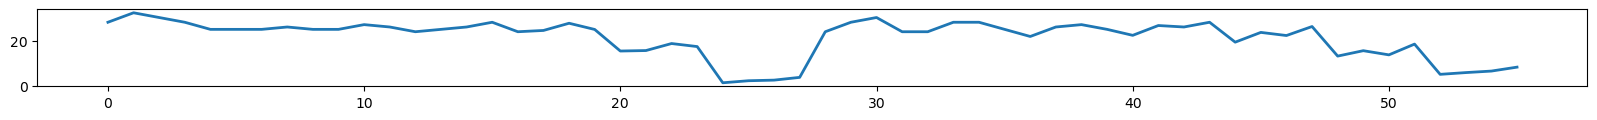

frequency:12 Hz    Mean Firing Rate(Hz): 21.632707595825195


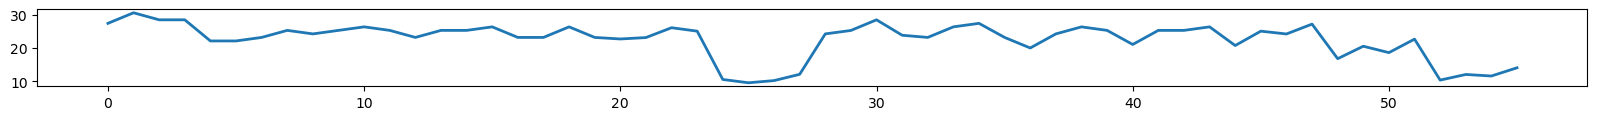

frequency:13 Hz    Mean Firing Rate(Hz): 22.552257537841797


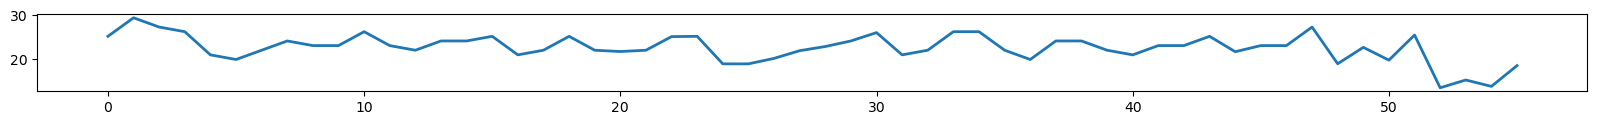

frequency:14 Hz    Mean Firing Rate(Hz): 22.69548988342285


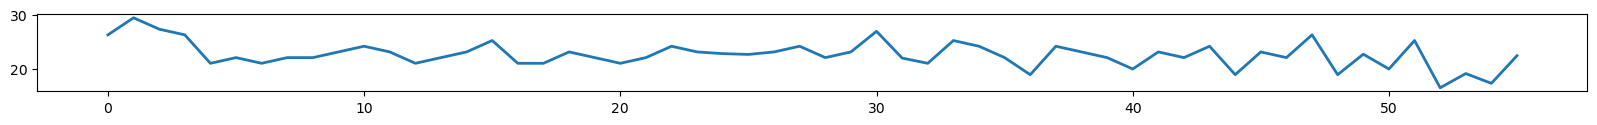

frequency:15 Hz    Mean Firing Rate(Hz): 22.652631759643555


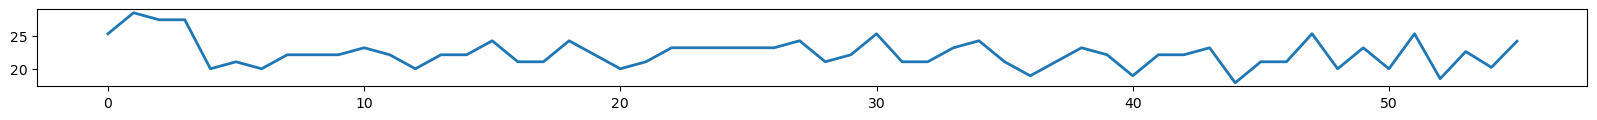

frequency:16 Hz    Mean Firing Rate(Hz): 22.29661750793457


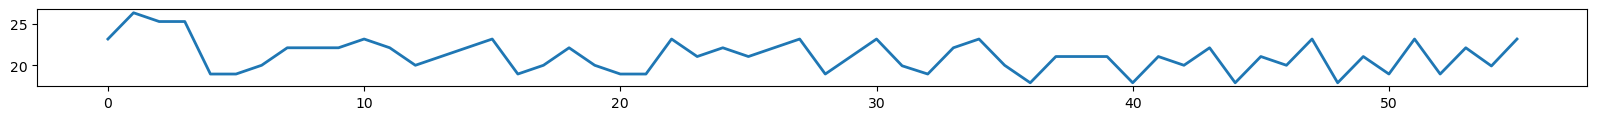

frequency:17 Hz    Mean Firing Rate(Hz): 21.143985748291016


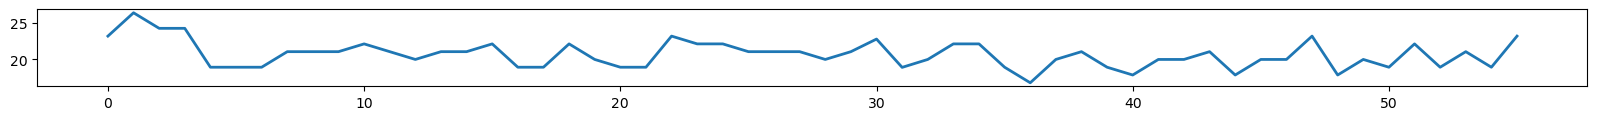

Trials:   5%|▌         | 1/20 [00:59<18:43, 59.11s/it]

frequency:18 Hz    Mean Firing Rate(Hz): 20.669172286987305


Trials: 100%|██████████| 20/20 [19:34<00:00, 58.71s/it]


In [21]:
num_trials = 20
num_speed = range(1,19, 1) # Frequencies from 80 to 100 with a step of 1
num_stim = 1000

data = []
labels = []

# Run the trials
for trial in tqdm(range(num_trials), desc="Trials"):
    # Generate the stimuli for each frequency
    for speed in tqdm(num_speed, desc=f"Trial {trial+1} - mm/s speed", leave=False):
        # Generate the stimulus
        stim =  generate_speed_bar_stimuli(num_stim=1000, speed=speed, direction='vert', angle=0, pixel_h=64, pixel_w=48, F=10, show_frames=[])

        S = SNN(R, device = device, noise_std_val = 2)  # Update with your SNN initialization method
        S.feedforward(stim)
        plot_figure = (trial == 0)

        mean_firing_rates = plot_SNN(S,layers = [],plot_figure = plot_figure,fig_size = (20,1))

        if trial == 0:
            print('frequency:' + str(speed) +' Hz   ' + ' Mean Firing Rate(Hz): ' + str(torch.mean(mean_firing_rates).item()))
        # if trial == 1:
        
        #     mean_firing_rates = plot_SNN(S,layers=['cn'],plot_figure = True,fig_size = (20,1))
        
        # plot_mean_firing_rates(S.ra_spike_times[0],bin_size = 50, fig_size = (20,1))

        # Save the data and labels
        data.append(mean_firing_rates.cpu().numpy())
        labels.append(speed)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

np.save('data_svm_angle.npy', data)
np.save('labels_svm_angle.npy', labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create and train the SVM
clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
clf.fit(X_train, y_train)

# Test the SVM
y_pred = clf.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# print(X_train.shape)
# print(X_test.shape)
# print(y_train)
# print(y_test)

# Identify the misclassified samples
misclassified = np.where(y_test != y_pred)

# Print the misclassified labels
print("Misclassified labels               : ", y_test[misclassified])
print("Test output of misclassified labels: ", y_pred[misclassified])
# Print the indices of the misclassified samples
# print("Indices of misclassified samples: ", misclassified)

C:\Users\JaehunKim\AppData\Local\Temp\ipykernel_36632\1793275496.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # Choose any colormap that you like


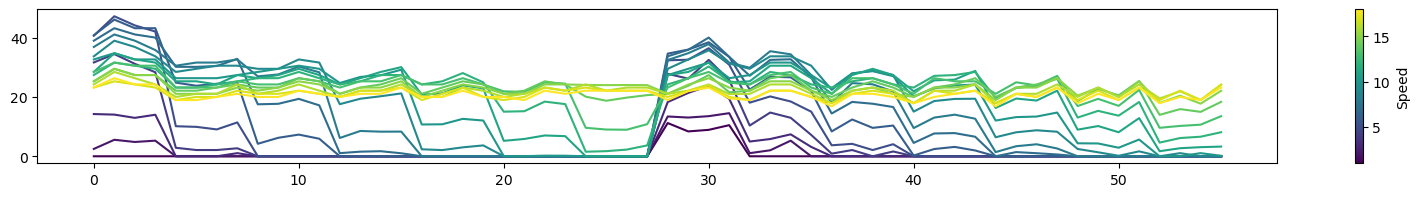

In [20]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots(figsize=(20, 2))  # Create a figure and a set of subplots

# Create a colormap
cmap = cm.get_cmap('viridis')  # Choose any colormap that you like
color_norm = plt.Normalize(vmin=min(num_speed), vmax=max(num_speed))

# Run the trials
    # Generate the stimuli for each frequency
for speed in tqdm(num_speed, desc=f"Trial {trial+1} - mm/s speed", leave=False):
    # Generate the stimulus
    stim =  generate_speed_bar_stimuli(num_stim=1000, speed=speed, direction='vert', angle=0, pixel_h=64, pixel_w=48, F=10, show_frames=[])

    S = SNN(R, device = device, noise_std_val = 2)  # Update with your SNN initialization method
    S.feedforward(stim)

    mean_firing_rates = plot_SNN(S,layers = [],plot_figure = False,fig_size = (20,1))  # Set plot_figure to False

    # Plot the mean firing rates for each speed on the same figure
    ax.plot(mean_firing_rates.cpu().numpy(), color=cmap(color_norm(speed)))

# Add a color bar
cbar = plt.colorbar(cm.ScalarMappable(norm=color_norm, cmap=cmap), ax=ax)
cbar.set_label('Speed')

plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np

num_trials = 20
num_speed = range(1,10, 1) # Frequencies from 80 to 100 with a step of 1
num_stim = 300
noise_std_values = range(1,13, 1)
window_sizes = range(1, 270, 20)  # Window sizes from 0 to 200 with a step of 10

# Initialize an accuracy matrix to store the accuracy for each combination of window size and noise_std
accuracy_matrix = np.zeros((len(window_sizes), len(noise_std_values)))

plot_figure = 0 

# Iterate over all combinations of window size and noise_std values
for j, noise_std in enumerate(noise_std_values):
    # Initialize empty lists to store data and labels
    data_per_noise = []
    labels_per_noise = []
    # Run the trials
    for trial in range(num_trials):
        # Generate the stimuli for each frequency
        for speed in num_speed:
            print(f", noise_std: {noise_std} - Running trial {trial+1} mm/s speed: {speed}, num_stim: {num_stim}")
            # Generate the stimulus
            stim =  generate_speed_bar_stimuli(num_stim=num_stim, speed=speed, direction='vert', angle=0, pixel_h=64, pixel_w=48, F=10, show_frames=[])

            S = SNN(R, device = device, noise_std_val = noise_std)  # Update with your SNN initialization method
            S.feedforward(stim)
            # plot_figure = (trial == 0)
            spike_times = S.cn_spike_times[1]
            # mean_firing_rates = plot_SNN(S,layers = [],plot_figure = plot_figure,fig_size = (20,1))

            # Save the spike_times and labels
            data_per_noise.append(spike_times.cpu().numpy())
            labels_per_noise.append(speed)

    # Convert spike_times and labels to numpy arrays
    spike_times = np.array(data_per_noise)
    labels = np.array(labels_per_noise)

    for i, window_size in enumerate(window_sizes):
        # Compute firing rates for each window size
        data = []
        for spike_time in spike_times:
            mean_firing_rate = compute_individual_firing_rates(spike_time, window_size)
            data.append(mean_firing_rate)

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

        # Create and train the SVM
        clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
        clf.fit(X_train, y_train)

        # Test the SVM
        y_pred = clf.predict(X_test)

        # Get the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store the accuracy in the accuracy matrix
        accuracy_matrix[i, j] = accuracy

        # Print the accuracy
        print(f"For window size {window_size} and noise_std {noise_std}, Accuracy: ", accuracy)

# Print the final accuracy matrix
print("Accuracy matrix: ", accuracy_matrix)


, noise_std: 1 - Running trial 1 mm/s speed: 1, num_stim: 300
, noise_std: 1 - Running trial 1 mm/s speed: 2, num_stim: 300
, noise_std: 1 - Running trial 1 mm/s speed: 3, num_stim: 300
, noise_std: 1 - Running trial 1 mm/s speed: 4, num_stim: 300
, noise_std: 1 - Running trial 1 mm/s speed: 5, num_stim: 300
, noise_std: 1 - Running trial 1 mm/s speed: 6, num_stim: 300
, noise_std: 1 - Running trial 1 mm/s speed: 7, num_stim: 300
, noise_std: 1 - Running trial 1 mm/s speed: 8, num_stim: 300
, noise_std: 1 - Running trial 1 mm/s speed: 9, num_stim: 300
, noise_std: 1 - Running trial 2 mm/s speed: 1, num_stim: 300
, noise_std: 1 - Running trial 2 mm/s speed: 2, num_stim: 300
, noise_std: 1 - Running trial 2 mm/s speed: 3, num_stim: 300
, noise_std: 1 - Running trial 2 mm/s speed: 4, num_stim: 300
, noise_std: 1 - Running trial 2 mm/s speed: 5, num_stim: 300
, noise_std: 1 - Running trial 2 mm/s speed: 6, num_stim: 300
, noise_std: 1 - Running trial 2 mm/s speed: 7, num_stim: 300
, noise_

Accuracy matrix:  [[0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
  0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778]
 [0.02777778 0.02777778 0.02777778 0.02777778 0.05555556 0.16666667
  0.08333333 0.19444444 0.16666667 0.13888889 0.25       0.16666667]
 [0.02777778 0.02777778 0.05555556 0.19444444 0.13888889 0.13888889
  0.11111111 0.05555556 0.08333333 0.16666667 0.11111111 0.05555556]
 [0.02777778 0.02777778 0.05555556 0.11111111 0.19444444 0.16666667
  0.08333333 0.05555556 0.16666667 0.19444444 0.11111111 0.16666667]
 [0.02777778 0.08333333 0.13888889 0.16666667 0.22222222 0.22222222
  0.19444444 0.16666667 0.16666667 0.19444444 0.08333333 0.11111111]
 [0.22222222 0.33333333 0.25       0.22222222 0.22222222 0.25
  0.30555556 0.25       0.16666667 0.16666667 0.19444444 0.22222222]
 [0.5        0.52777778 0.58333333 0.44444444 0.38888889 0.25
  0.44444444 0.22222222 0.25       0.22222222 0.19444444 0.25      ]
 [0.55555556 0.66666667 0.61111111 

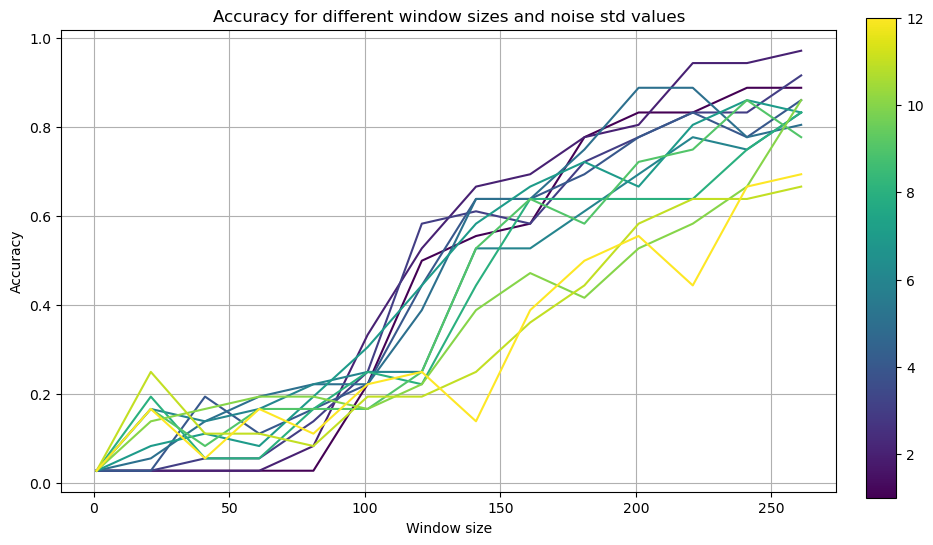

In [29]:
import matplotlib.cm as cm
import matplotlib as mpl

print("Accuracy matrix: ", accuracy_matrix)

plt.figure(figsize=(10, 6))
colors = cm.viridis(np.linspace(0, 1, len(noise_std_values)))

for i, noise_std in enumerate(noise_std_values):
    plt.plot(window_sizes, [row[i] for row in accuracy_matrix], color=colors[i])

plt.xlabel('Window size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.title('Accuracy for different window sizes and noise std values')

# Colorbar
cax = plt.axes([0.93, 0.1, 0.03, 0.8])
norm = mpl.colors.Normalize(vmin=min(noise_std_values), vmax=max(noise_std_values))
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=cax)

plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(accuracy_matrix, origin='lower', aspect='auto', cmap='viridis', 
           extent=[min(noise_std_values), max(noise_std_values), min(window_sizes), max(window_sizes)])
plt.colorbar(label='Accuracy')
plt.xlabel('Noise std')
plt.ylabel('Window size')
plt.title('Accuracy for different window sizes and noise std values')
plt.show()

# Create a descriptive filename
filename = f"accuracy_matrix_trials{num_trials}_speed{min(num_speed)}to{max(num_speed)}_stim{num_stim}_noise{min(noise_std_values)}to{max(noise_std_values)}_window{min(window_sizes)}to{max(window_sizes)}.npy"

# Save the file
np.save(filename, accuracy_matrix)



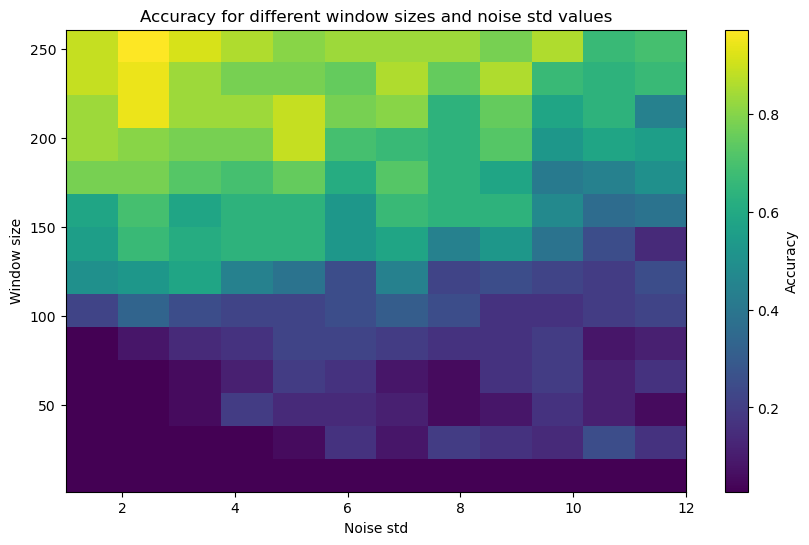

In [30]:
plt.figure(figsize=(10, 6))
plt.imshow(accuracy_matrix, origin='lower', aspect='auto', cmap='viridis', 
           extent=[min(noise_std_values), max(noise_std_values), min(window_sizes), max(window_sizes)])
plt.colorbar(label='Accuracy')
plt.xlabel('Noise std')
plt.ylabel('Window size')
plt.title('Accuracy for different window sizes and noise std values')
plt.show()

[3.141592653589793]
torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_rf shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_rf shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_rf shape:  torch.Size([54, 54])
ra_intopn_rf shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([28, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([28, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([28, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([28, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn_

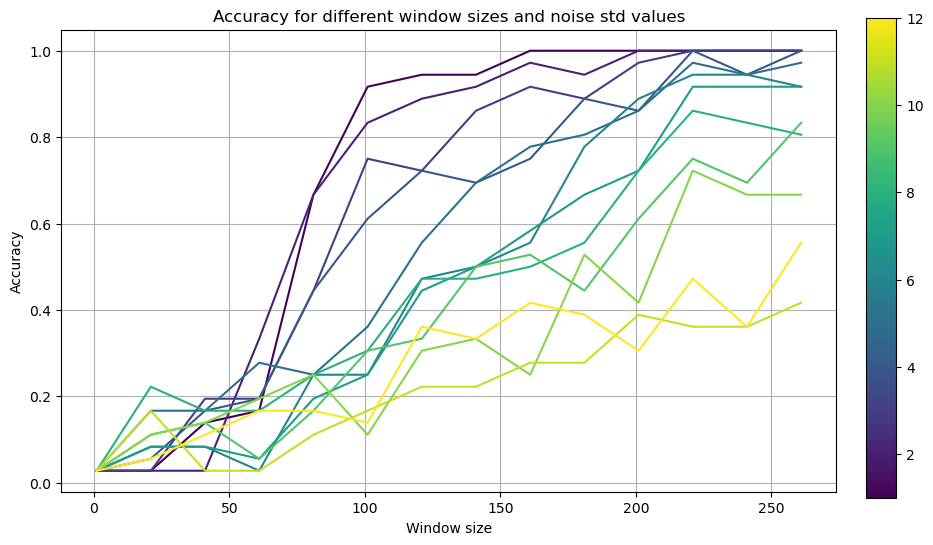

In [31]:
R_vert = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output = [np.pi], plot_receptive_field = False,plot_ind = 1)

num_trials = 20
num_speed = range(1,10, 1) # Frequencies from 80 to 100 with a step of 1
num_stim = 300
noise_std_values = range(1,13, 1)
window_sizes = range(1, 270, 20)  # Window sizes from 0 to 200 with a step of 10

# Initialize an accuracy matrix to store the accuracy for each combination of window size and noise_std
accuracy_matrix = np.zeros((len(window_sizes), len(noise_std_values)))

plot_figure = 0 

# Iterate over all combinations of window size and noise_std values
for j, noise_std in enumerate(noise_std_values):
    # Initialize empty lists to store data and labels
    data_per_noise = []
    labels_per_noise = []
    # Run the trials
    for trial in range(num_trials):
        # Generate the stimuli for each frequency
        for speed in num_speed:
            print(f", noise_std: {noise_std} - Running trial {trial+1} mm/s speed: {speed}, num_stim: {num_stim}")
            # Generate the stimulus
            stim =  generate_speed_bar_stimuli(num_stim=num_stim, speed=speed, direction='vert', angle=0, pixel_h=64, pixel_w=48, F=10, show_frames=[])

            S = SNN(R_vert, device = device, noise_std_val = noise_std)  # Update with your SNN initialization method
            S.feedforward(stim)
            # plot_figure = (trial == 0)
            spike_times = S.cn_spike_times[1]
            # mean_firing_rates = plot_SNN(S,layers = [],plot_figure = plot_figure,fig_size = (20,1))

            # Save the spike_times and labels
            data_per_noise.append(spike_times.cpu().numpy())
            labels_per_noise.append(speed)

    # Convert spike_times and labels to numpy arrays
    spike_times = np.array(data_per_noise)
    labels = np.array(labels_per_noise)

    for i, window_size in enumerate(window_sizes):
        # Compute firing rates for each window size
        data = []
        for spike_time in spike_times:
            mean_firing_rate = compute_individual_firing_rates(spike_time, window_size)
            data.append(mean_firing_rate)

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

        # Create and train the SVM
        clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
        clf.fit(X_train, y_train)

        # Test the SVM
        y_pred = clf.predict(X_test)

        # Get the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store the accuracy in the accuracy matrix
        accuracy_matrix[i, j] = accuracy

        # Print the accuracy
        print(f"For window size {window_size} and noise_std {noise_std}, Accuracy: ", accuracy)

# Print the final accuracy matrix
print("Accuracy matrix: ", accuracy_matrix)


plt.figure(figsize=(10, 6))
colors = cm.viridis(np.linspace(0, 1, len(noise_std_values)))

for i, noise_std in enumerate(noise_std_values):
    plt.plot(window_sizes, [row[i] for row in accuracy_matrix], color=colors[i])

plt.xlabel('Window size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.title('Accuracy for different window sizes and noise std values')

# Colorbar
cax = plt.axes([0.93, 0.1, 0.03, 0.8])
norm = mpl.colors.Normalize(vmin=min(noise_std_values), vmax=max(noise_std_values))
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=cax)

plt.show()

# Create a descriptive filename
filename = f"accuracy_matrix_trials{num_trials}_speed{min(num_speed)}to{max(num_speed)}_stim{num_stim}_noise{min(noise_std_values)}to{max(noise_std_values)}_window{min(window_sizes)}to{max(window_sizes)}.npy"


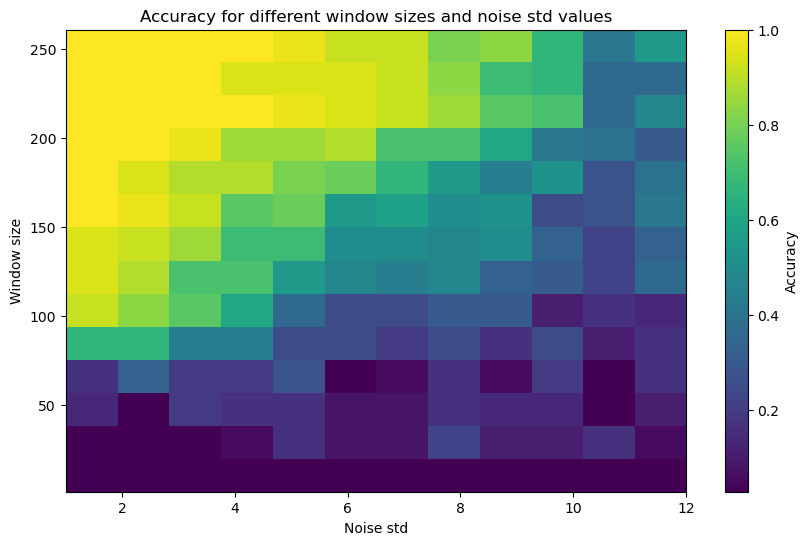

In [32]:
plt.figure(figsize=(10, 6))
plt.imshow(accuracy_matrix, origin='lower', aspect='auto', cmap='viridis', 
           extent=[min(noise_std_values), max(noise_std_values), min(window_sizes), max(window_sizes)])
plt.colorbar(label='Accuracy')
plt.xlabel('Noise std')
plt.ylabel('Window size')
plt.title('Accuracy for different window sizes and noise std values')
plt.show()

[1.5707963267948966, 3.141592653589793]
torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_rf shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_rf shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_rf shape:  torch.Size([54, 54])
ra_intopn_rf shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([56, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([56, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([56, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([56, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_

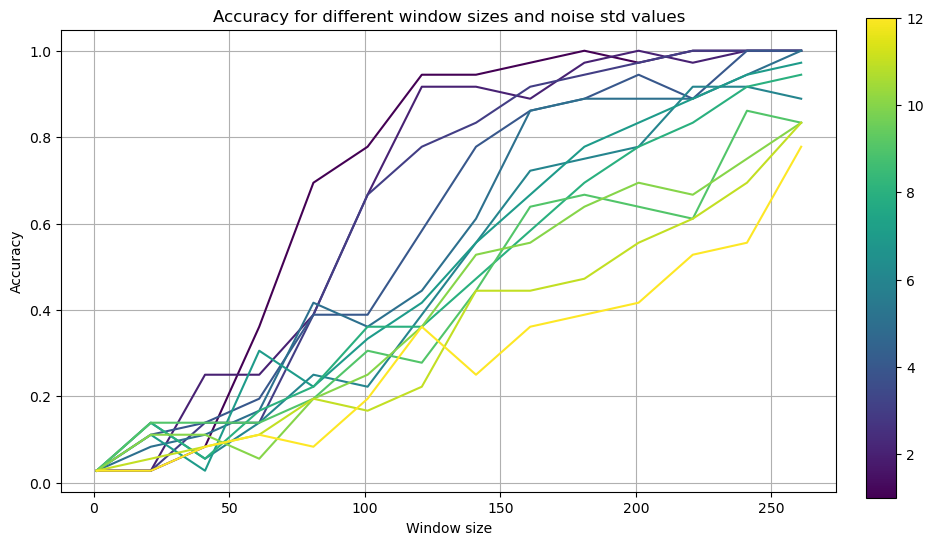

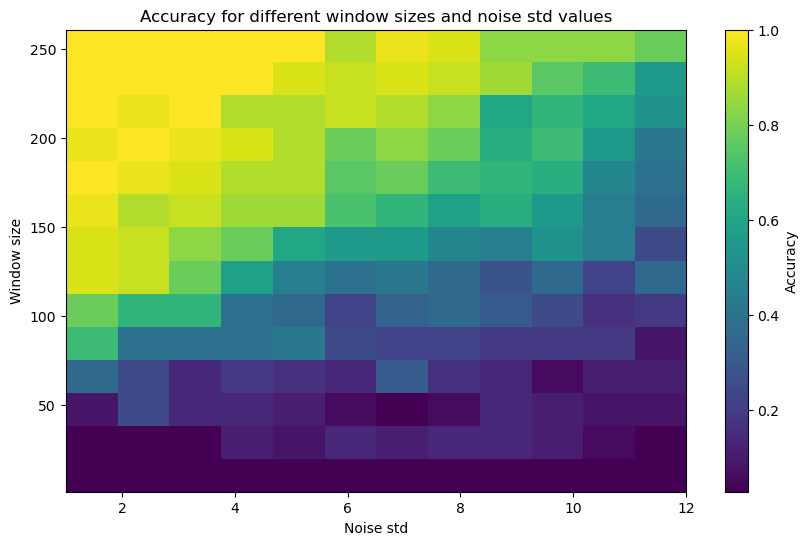

In [33]:
R_vert = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output = [np.pi/2,np.pi], plot_receptive_field = False,plot_ind = 1)

num_trials = 20
num_speed = range(1,10, 1) # Frequencies from 80 to 100 with a step of 1
num_stim = 300
noise_std_values = range(1,13, 1)
window_sizes = range(1, 270, 20)  # Window sizes from 0 to 200 with a step of 10

# Initialize an accuracy matrix to store the accuracy for each combination of window size and noise_std
accuracy_matrix = np.zeros((len(window_sizes), len(noise_std_values)))

plot_figure = 0 

# Iterate over all combinations of window size and noise_std values
for j, noise_std in enumerate(noise_std_values):
    # Initialize empty lists to store data and labels
    data_per_noise = []
    labels_per_noise = []
    # Run the trials
    for trial in range(num_trials):
        # Generate the stimuli for each frequency
        for speed in num_speed:
            print(f", noise_std: {noise_std} - Running trial {trial+1} mm/s speed: {speed}, num_stim: {num_stim}")
            # Generate the stimulus
            stim =  generate_speed_bar_stimuli(num_stim=num_stim, speed=speed, direction='vert', angle=0, pixel_h=64, pixel_w=48, F=10, show_frames=[])

            S = SNN(R_vert, device = device, noise_std_val = noise_std)  # Update with your SNN initialization method
            S.feedforward(stim)
            # plot_figure = (trial == 0)
            spike_times = S.cn_spike_times[1]
            # mean_firing_rates = plot_SNN(S,layers = [],plot_figure = plot_figure,fig_size = (20,1))

            # Save the spike_times and labels
            data_per_noise.append(spike_times.cpu().numpy())
            labels_per_noise.append(speed)

    # Convert spike_times and labels to numpy arrays
    spike_times = np.array(data_per_noise)
    labels = np.array(labels_per_noise)

    for i, window_size in enumerate(window_sizes):
        # Compute firing rates for each window size
        data = []
        for spike_time in spike_times:
            mean_firing_rate = compute_individual_firing_rates(spike_time, window_size)
            data.append(mean_firing_rate)

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

        # Create and train the SVM
        clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
        clf.fit(X_train, y_train)

        # Test the SVM
        y_pred = clf.predict(X_test)

        # Get the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store the accuracy in the accuracy matrix
        accuracy_matrix[i, j] = accuracy

        # Print the accuracy
        print(f"For window size {window_size} and noise_std {noise_std}, Accuracy: ", accuracy)

# Print the final accuracy matrix
print("Accuracy matrix: ", accuracy_matrix)


plt.figure(figsize=(10, 6))
colors = cm.viridis(np.linspace(0, 1, len(noise_std_values)))

for i, noise_std in enumerate(noise_std_values):
    plt.plot(window_sizes, [row[i] for row in accuracy_matrix], color=colors[i])

plt.xlabel('Window size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.title('Accuracy for different window sizes and noise std values')

# Colorbar
cax = plt.axes([0.93, 0.1, 0.03, 0.8])
norm = mpl.colors.Normalize(vmin=min(noise_std_values), vmax=max(noise_std_values))
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=cax)

plt.show()

# Create a descriptive filename
filename = f"accuracy_matrix_trials{num_trials}_speed{min(num_speed)}to{max(num_speed)}_stim{num_stim}_noise{min(noise_std_values)}to{max(noise_std_values)}_window{min(window_sizes)}to{max(window_sizes)}.npy"

plt.figure(figsize=(10, 6))
plt.imshow(accuracy_matrix, origin='lower', aspect='auto', cmap='viridis', 
           extent=[min(noise_std_values), max(noise_std_values), min(window_sizes), max(window_sizes)])
plt.colorbar(label='Accuracy')
plt.xlabel('Noise std')
plt.ylabel('Window size')
plt.title('Accuracy for different window sizes and noise std values')
plt.show()